In [21]:
!pip -q install pandas pyarrow seaborn matplotlib

In [26]:
import os
from collections import Counter

import pandas as pd
import pyarrow.parquet as pq
import pyarrow.dataset as ds

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
import kagglehub

path = kagglehub.dataset_download("alexxl/megamarket")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/megamarket


In [29]:
import os

data_path = os.path.join(path, "megamarket.parquet")

In [30]:
print("== schema ==")
schema = pq.read_schema(data_path)
print(schema)

== schema ==
user_id: int32
datetime: timestamp[ms]
event: int32
item_id: int32
category_id: int32
price: float


In [31]:
cols = ["user_id","datetime","event","item_id","category_id","price"]
scanner = ds.dataset(data_path, format="parquet").scanner(columns=cols, batch_size=100_000)
limit = 100_000
parts = []
taken = 0
for batch in scanner.to_batches():
    dfb = batch.to_pandas()
    parts.append(dfb)
    taken += len(dfb)
    if taken >= limit:
        break

df_head = pd.concat(parts, ignore_index=True).head(limit)
print(df_head.head())
print("head shape:", df_head.shape)

   user_id                datetime  event  item_id  category_id     price
0  1199174 2023-02-13 03:12:19.131      2  1861088         5395 -0.042062
1  3124963 2023-02-13 09:38:55.674      2  2084441         1531  0.079817
2  2106055 2023-02-13 08:26:05.004      2  2586689         9294 -0.038990
3  4169844 2023-02-13 16:55:08.470      2  2586689         9294 -0.038990
4  7472260 2023-02-13 03:30:13.093      2  2586689         9294 -0.038990
head shape: (100000, 6)


In [32]:
cols_full = ["user_id","item_id","category_id","event","datetime","price"]
scanner = ds.dataset(data_path, format="parquet").scanner(columns=cols_full, batch_size=1_000_000)

event_cnt = Counter()
user_cnt = Counter()
item_cnt = Counter()
cat_cnt = Counter()
daily_cnt = Counter()

min_dt = None
max_dt = None
total = 0

for batch in scanner.to_batches():
    df = batch.to_pandas()
    n = len(df)
    total += n

    event_cnt.update(df["event"].astype("int64"))
    user_cnt.update(df["user_id"].astype("int64"))
    item_cnt.update(df["item_id"].astype("int64"))
    cat_cnt.update(df["category_id"].astype("int64"))

    d = pd.to_datetime(df["datetime"]).dt.date
    daily_cnt.update(d)
    dmin, dmax = d.min(), d.max()
    min_dt = dmin if min_dt is None or dmin < min_dt else min_dt
    max_dt = dmax if max_dt is None or dmax > max_dt else max_dt

    if total >= 10_000_000:
        break

print({
    "interactions": total,
    "users": len(user_cnt),
    "items": len(item_cnt),
    "categories": len(cat_cnt),
    "dt_min": str(min_dt),
    "dt_max": str(max_dt),
})

{'interactions': 10001446, 'users': 554080, 'items': 914426, 'categories': 9152, 'dt_min': '2023-02-10', 'dt_max': '2023-05-13'}


In [34]:
event_df = pd.DataFrame(sorted(event_cnt.items()), columns=["event","cnt"])
if len(event_df):
    event_df["pct"] = (event_df["cnt"] * 100 / event_df["cnt"].sum()).round(4)

daily_df = pd.DataFrame(daily_cnt.items(), columns=["date","interactions"]).sort_values("date")
user_freq = pd.Series(list(user_cnt.values()))
item_freq = pd.Series(list(item_cnt.values()))

In [ ]:
event_df = pd.DataFrame(sorted(event_cnt.items()), columns=["event","cnt"])
if len(event_df):
    event_df["pct"] = (event_df["cnt"] * 100 / event_df["cnt"].sum()).round(4)

daily_df = pd.DataFrame(daily_cnt.items(), columns=["date","interactions"]).sort_values("date")
user_freq = pd.Series(list(user_cnt.values()))
item_freq = pd.Series(list(item_cnt.values()))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


plots saved in: /kaggle/working


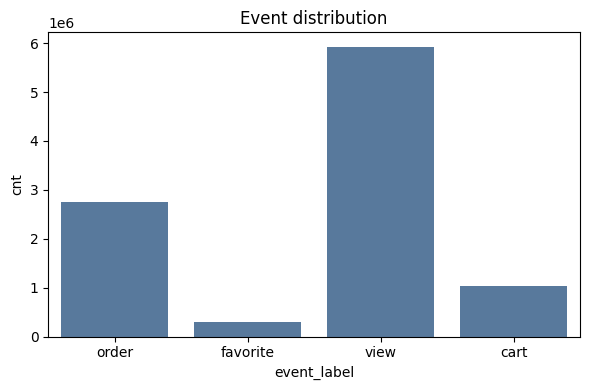

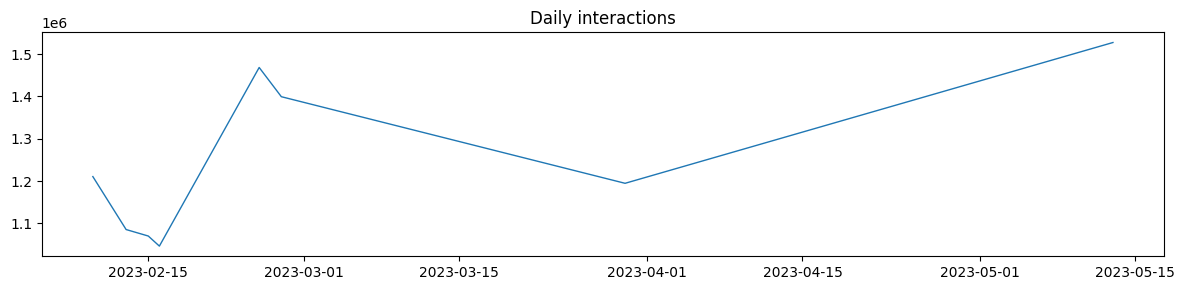

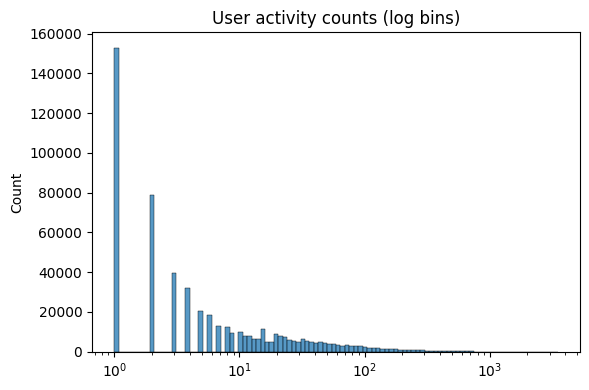

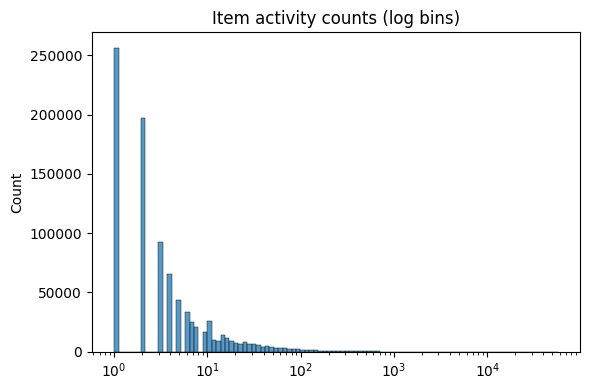

In [37]:
out_dir = "/kaggle/working" if os.path.exists("/kaggle/working") else "."
os.makedirs(out_dir, exist_ok=True)

event_labels = {0:"order", 1:"favorite", 2:"view", 3:"cart"}
event_plot = event_df.assign(event_label=event_df["event"].map(event_labels))

plt.figure(figsize=(6,4))
sns.barplot(data=event_plot, x="event_label", y="cnt", color="#4C78A8")
plt.title("Event distribution"); plt.tight_layout();
plt.savefig(os.path.join(out_dir, "event_distribution.png"), dpi=150)

plt.figure(figsize=(12,3))
plt.plot(daily_df["date"], daily_df["interactions"], lw=1)
plt.title("Daily interactions"); plt.tight_layout();
plt.savefig(os.path.join(out_dir, "daily_interactions.png"), dpi=150)

plt.figure(figsize=(6,4))
sns.histplot(user_freq, bins=100, log_scale=True)
plt.title("User activity counts (log bins)"); plt.tight_layout();
plt.savefig(os.path.join(out_dir, "user_freq_hist.png"), dpi=150)

plt.figure(figsize=(6,4))
sns.histplot(item_freq, bins=100, log_scale=True)
plt.title("Item activity counts (log bins)"); plt.tight_layout();
plt.savefig(os.path.join(out_dir, "item_freq_hist.png"), dpi=150)

print("plots saved in:", out_dir)

In [38]:
event_df.to_csv(os.path.join(out_dir, "event_distribution.csv"), index=False)
daily_df.to_csv(os.path.join(out_dir, "daily_interactions.csv"), index=False)
user_freq.to_frame("cnt").to_csv(os.path.join(out_dir, "user_freq.csv"), index=False)
item_freq.to_frame("cnt").to_csv(os.path.join(out_dir, "item_freq.csv"), index=False)
print("saved csv to:", out_dir)

saved csv to: /kaggle/working


In [39]:
import numpy as np
from collections import defaultdict

In [40]:
cols = ["user_id","event"]
scanner = ds.dataset(data_path, format="parquet").scanner(columns=cols, batch_size=1_000_000)

user_has = defaultdict(lambda: {0:False,1:False,2:False,3:False})
user_seen = set()
max_rows = 10_000_000
processed = 0
for batch in scanner.to_batches():
    df = batch.to_pandas()
    for ev, grp in df.groupby("event"):
        for u in grp["user_id"].astype("int64").unique():
            user_has[int(u)][int(ev)] = True
            user_seen.add(int(u))
    processed += len(df)
    if processed >= max_rows:
        break

def share(flag):
    if not user_seen:
        return 0.0
    return round(100.0 * sum(1 for u in user_seen if user_has[u][flag]) / len(user_seen), 4)

event_user_share = pd.DataFrame([
    {"event": 0, "label": "order",    "user_share_pct": share(0)},
    {"event": 1, "label": "favorite", "user_share_pct": share(1)},
    {"event": 2, "label": "view",     "user_share_pct": share(2)},
    {"event": 3, "label": "cart",     "user_share_pct": share(3)},
])
print(event_user_share)
event_user_share.to_csv(os.path.join(out_dir, "event_user_share.csv"), index=False)

   event     label  user_share_pct
0      0     order         76.2135
1      1  favorite         10.2108
2      2      view         34.6890
3      3      cart         21.6216


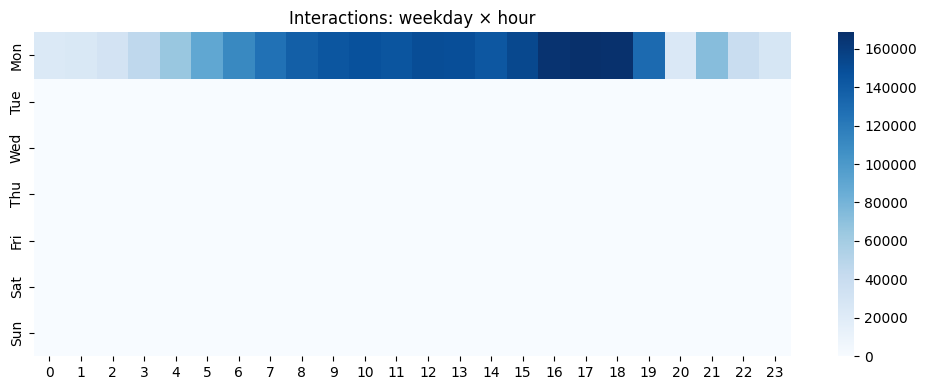

In [41]:
cols = ["datetime"]
scanner = ds.dataset(data_path, format="parquet").scanner(columns=cols, batch_size=1_000_000)
wdh = np.zeros((7,24), dtype=np.int64)
processed = 0
max_rows = 10_000_000
for batch in scanner.to_batches():
    s = pd.to_datetime(batch.column("datetime").to_pandas())
    for wd, hr, cnt in zip(s.dt.dayofweek.value_counts().index,
                            [s[s.dt.dayofweek==i].dt.hour.value_counts().to_dict() for i in range(7)],
                            [s[s.dt.dayofweek==i].dt.hour.value_counts() for i in range(7)]):
        d = cnt.to_dict()
        for h, v in d.items():
            wdh[int(wd), int(h)] += int(v)
    processed += len(s)
    if processed >= max_rows:
        break

wdh_df = pd.DataFrame(wdh, index=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], columns=list(range(24)))
plt.figure(figsize=(10,4))
sns.heatmap(wdh_df, cmap="Blues")
plt.title("Interactions: weekday × hour")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "weekday_hour_heatmap.png"), dpi=150)

In [45]:
!pip -q install tqdm

In [47]:
from tqdm.auto import tqdm

In [48]:
batch_size = 1_000_000
max_rows = 10_000_000

scanner = ds.dataset(data_path, format="parquet").scanner(
    columns=["event", "price", "category_id"],
    batch_size=batch_size,
)

sum_by_event = defaultdict(float)
n_by_event   = defaultdict(int)
sum_by_cat   = defaultdict(float)
n_by_cat     = defaultdict(int)

processed = 0
pbar = tqdm(unit="rows", unit_scale=True, desc="price aggregations")
for batch in scanner.to_batches():
    df = batch.to_pandas()
    processed += len(df)
    pbar.update(len(df))

    s = pd.to_numeric(df["price"], errors="coerce")
    df = df.assign(price=s)

    grp_e = df.groupby("event", dropna=False)["price"]
    n_by_event_batch = grp_e.count()
    sum_by_event_batch = grp_e.sum(min_count=1)

    for ev, n in n_by_event_batch.items():
        if n and pd.notna(n):
            ev_int = int(ev) if pd.notna(ev) else -1
            n_by_event[ev_int] += int(n)
            sum_by_event[ev_int] += float(sum_by_event_batch.loc[ev])

    grp_c = df.groupby("category_id", dropna=False)["price"]
    n_by_cat_batch = grp_c.count()
    sum_by_cat_batch = grp_c.sum(min_count=1)

    for cid, n in n_by_cat_batch.items():
        if n and pd.notna(n):
            cid_int = int(cid) if pd.notna(cid) else -1
            n_by_cat[cid_int] += int(n)
            sum_by_cat[cid_int] += float(sum_by_cat_batch.loc[cid])

    if max_rows is not None and processed >= max_rows:
        break
pbar.close()

price_event_df = pd.DataFrame(
    [{"event": ev, "mean_price": (sum_by_event[ev] / n_by_event[ev]) if n_by_event[ev] else None}
     for ev in sorted(n_by_event.keys())]
).sort_values("event")

top_cat_ids = sorted(n_by_cat, key=n_by_cat.get, reverse=True)[:20]
price_cat_df = pd.DataFrame(
    [{"category_id": cid, "n": n_by_cat[cid],
      "mean_price": (sum_by_cat[cid] / n_by_cat[cid]) if n_by_cat[cid] else None}
     for cid in top_cat_ids]
).sort_values("n", ascending=False)

print("price_event_df:")
print(price_event_df)
print("\nprice_cat_df (top-20 by count):")
print(price_cat_df)

price aggregations: 0.00rows [00:00, ?rows/s]

price_event_df:
   event  mean_price
0      0   -0.034428
1      1   -0.013271
2      2    0.009137
3      3   -0.026963

price_cat_df (top-20 by count):
    category_id       n  mean_price
0          6580  178335   -0.042121
1          7471  154703    0.071780
2          3647  120282   -0.042689
3          5064  106367   -0.008016
4           734   97072   -0.042530
5          6077   88215   -0.033715
6          7287   86821   -0.042560
7          5432   74624   -0.042573
8          2400   74383   -0.042629
9          7305   68227   -0.039852
10          517   64241   -0.042579
11         4480   56755    0.219902
12         4317   53731   -0.042540
13         3018   49414   -0.041856
14         1351   48389    0.221360
15         9853   45392    0.005024
16         4802   45178   -0.027994
17         4239   44615   -0.041898
18         9379   42394   -0.038034
19         2433   42330   -0.042647


In [50]:
dt_max = pd.to_datetime(daily_df["date"].max())
t_test_days = 14
t_val_days = 14
cut1 = dt_max - pd.Timedelta(days=t_test_days)
cut0 = dt_max - pd.Timedelta(days=t_test_days + t_val_days)

sets = {
    "train_users": set(), "val_users": set(), "test_users": set(),
    "train_items": set(), "val_items": set(), "test_items": set(),
}

batch_size = 1_000_000
max_rows = 10_000_000

scanner = ds.dataset(
    data_path, format="parquet"
).scanner(
    columns=["user_id", "item_id", "datetime"],
    batch_size=batch_size
)

processed = 0
pbar = tqdm(unit="rows", unit_scale=True, desc="temporal split coverage")
for batch in scanner.to_batches():
    df = batch.to_pandas()
    processed += len(df)
    pbar.update(len(df))

    d = pd.to_datetime(df["datetime"]).dt.tz_localize(None)
    mask_train = d < cut0
    mask_val = (d >= cut0) and (d < cut1) if False else ((d >= cut0) & (d < cut1))
    mask_test = d >= cut1

    sets["train_users"].update(df.loc[mask_train, "user_id"].astype("int64").unique())
    sets["val_users"].update(df.loc[mask_val, "user_id"].astype("int64").unique())
    sets["test_users"].update(df.loc[mask_test, "user_id"].astype("int64").unique())

    sets["train_items"].update(df.loc[mask_train, "item_id"].astype("int64").unique())
    sets["val_items"].update(df.loc[mask_val, "item_id"].astype("int64").unique())
    sets["test_items"].update(df.loc[mask_test, "item_id"].astype("int64").unique())

    if max_rows is not None and processed >= max_rows:
        break
pbar.close()

def cov(a, b):
    return round(100.0 * len(a & b) / max(1, len(b)), 2)

report = {
    "users_train_only": len(sets["train_users"] - sets["val_users"] - sets["test_users"]),
    "users_val_only": len(sets["val_users"] - sets["train_users"] - sets["test_users"]),
    "users_test_only": len(sets["test_users"] - sets["train_users"] - sets["val_users"]),
    "items_train_only": len(sets["train_items"] - sets["val_items"] - sets["test_items"]),
    "users_overlap_train_val_%": cov(sets["train_users"], sets["val_users"]),
    "users_overlap_train_test_%": cov(sets["train_users"], sets["test_users"]),
    "items_overlap_train_val_%": cov(sets["train_items"], sets["val_items"]),
    "items_overlap_train_test_%": cov(sets["train_items"], sets["test_items"]),
}
print("temporal split coverage:", report)

temporal split coverage: 0.00rows [00:00, ?rows/s]

temporal split coverage: {'users_train_only': 435464, 'users_val_only': 0, 'users_test_only': 67595, 'items_train_only': 655069, 'users_overlap_train_val_%': 0.0, 'users_overlap_train_test_%': 43.01, 'items_overlap_train_val_%': 0.0, 'items_overlap_train_test_%': 57.76}


In [52]:
cols = ["user_id","datetime","event","item_id","category_id","price"]
scanner = ds.dataset(data_path, format="parquet").scanner(columns=cols, batch_size=1_000_000)

null_counts = {c:0 for c in cols}
row_count = 0
neg_price = 0
dup_approx = 0

max_rows = 10_000_000
processed = 0
pbar = tqdm(unit="rows", unit_scale=True, desc="data quality")
for batch in scanner.to_batches():
    df = batch.to_pandas()
    n = len(df)
    processed += n
    pbar.update(n)

    row_count += n
    for c in cols:
        null_counts[c] += int(df[c].isna().sum())

    neg_price += int(pd.to_numeric(df["price"], errors="coerce").lt(0).sum())
    dup_approx += int(df.duplicated(subset=["user_id","item_id","datetime","event"]).sum())

    if max_rows is not None and processed >= max_rows:
        break
pbar.close()

null_rates = {c: (null_counts[c]/row_count) for c in cols}
print("null_rates:", null_rates)
print("negative_prices:", neg_price)
print("approx_duplicate_rows:", dup_approx)

data quality: 0.00rows [00:00, ?rows/s]

null_rates: {'user_id': 0.0, 'datetime': 0.0, 'event': 0.0, 'item_id': 0.0, 'category_id': 0.0, 'price': 0.0}
negative_prices: 8377391
approx_duplicate_rows: 1003207


In [53]:
batch_size = 1_000_000
max_rows = 10_000_000

scanner = ds.dataset(data_path, format="parquet").scanner(
    columns=["event", "price", "category_id"],
    batch_size=batch_size,
)

sum_by_event = defaultdict(float); n_by_event = defaultdict(int)
sum_by_cat   = defaultdict(float); n_by_cat   = defaultdict(int)

processed = 0
pbar = tqdm(unit="rows", unit_scale=True, desc="price aggregations")
for batch in scanner.to_batches():
    df = batch.to_pandas()
    processed += len(df)
    pbar.update(len(df))

    s = pd.to_numeric(df["price"], errors="coerce")
    df = df.assign(price=s)

    ge = df.groupby("event", dropna=False)["price"]
    n_by_event_batch = ge.count()
    sum_by_event_batch = ge.sum(min_count=1)
    for ev, n in n_by_event_batch.items():
        if n and pd.notna(n):
            ev_int = int(ev) if pd.notna(ev) else -1
            n_by_event[ev_int] += int(n)
            sum_by_event[ev_int] += float(sum_by_event_batch.loc[ev])

    gc = df.groupby("category_id", dropna=False)["price"]
    n_by_cat_batch = gc.count()
    sum_by_cat_batch = gc.sum(min_count=1)
    for cid, n in n_by_cat_batch.items():
        if n and pd.notna(n):
            cid_int = int(cid) if pd.notna(cid) else -1
            n_by_cat[cid_int] += int(n)
            sum_by_cat[cid_int] += float(sum_by_cat_batch.loc[cid])

    if max_rows is not None and processed >= max_rows:
        break
pbar.close()

price_event_df = pd.DataFrame(
    [{"event": ev, "mean_price": (sum_by_event[ev]/n_by_event[ev]) if n_by_event[ev] else None}
     for ev in sorted(n_by_event.keys())]
).sort_values("event")

top_cat_ids = sorted(n_by_cat, key=n_by_cat.get, reverse=True)[:20]
price_cat_df = pd.DataFrame(
    [{"category_id": cid, "n": n_by_cat[cid],
      "mean_price": (sum_by_cat[cid]/n_by_cat[cid]) if n_by_cat[cid] else None}
     for cid in top_cat_ids]
).sort_values("n", ascending=False)

print("price_event_df:"); print(price_event_df)
print("\nprice_cat_df (top-20 by count):"); print(price_cat_df)

price aggregations: 0.00rows [00:00, ?rows/s]

price_event_df:
   event  mean_price
0      0   -0.034428
1      1   -0.013271
2      2    0.009137
3      3   -0.026963

price_cat_df (top-20 by count):
    category_id       n  mean_price
0          6580  178335   -0.042121
1          7471  154703    0.071780
2          3647  120282   -0.042689
3          5064  106367   -0.008016
4           734   97072   -0.042530
5          6077   88215   -0.033715
6          7287   86821   -0.042560
7          5432   74624   -0.042573
8          2400   74383   -0.042629
9          7305   68227   -0.039852
10          517   64241   -0.042579
11         4480   56755    0.219902
12         4317   53731   -0.042540
13         3018   49414   -0.041856
14         1351   48389    0.221360
15         9853   45392    0.005024
16         4802   45178   -0.027994
17         4239   44615   -0.041898
18         9379   42394   -0.038034
19         2433   42330   -0.042647


In [55]:
sample_users_n = 5000
window_minutes = 60
top_k_pairs = 50
batch_size = 1_000_000
max_rows = 10_000_000

users_sorted = pd.Series(list(user_cnt.keys()))
sample_users = set(users_sorted.sample(min(sample_users_n, len(users_sorted)), random_state=42).tolist())

scanner = ds.dataset(
    data_path, format="parquet"
).scanner(
    columns=["user_id", "item_id", "datetime"],
    batch_size=batch_size,
    filter=ds.field("user_id").isin(list(sample_users))
)

pairs = Counter()
processed = 0
pbar = tqdm(total=max_rows, unit="rows", unit_scale=True, desc="covisitation (rows)")
for batch in scanner.to_batches():
    df = batch.to_pandas().astype({"user_id": "int64", "item_id": "int64"})
    processed += len(df)
    pbar.update(min(len(df), max_rows - (processed - len(df))))

    df["dt"] = pd.to_datetime(df["datetime"])
    df.sort_values(["user_id", "dt"], inplace=True)

    for _, g in df.groupby("user_id"):
        idx = 0
        for i in range(len(g)):
            while g.iloc[i]["dt"] - g.iloc[idx]["dt"] > pd.Timedelta(minutes=window_minutes):
                idx += 1
            items = g.iloc[idx:i+1]["item_id"].tolist()
            for a in range(len(items)):
                for b in range(a + 1, len(items)):
                    pairs[(items[a], items[b])] += 1

    if processed >= max_rows:
        break
pbar.close()

top_pairs = pairs.most_common(top_k_pairs)
covis_df = pd.DataFrame(
    [{"item_a": a, "item_b": b, "cnt": c} for (a, b), c in top_pairs]
)
print(covis_df.head())
covis_df.to_csv(os.path.join(out_dir, "covisitation_top_pairs.csv"), index=False)

covisitation (rows):   0%|          | 0.00/10.0M [00:00<?, ?rows/s]

KeyboardInterrupt: 

In [56]:
scanner = ds.dataset(data_path, format="parquet").scanner(columns=["user_id","datetime"], batch_size=1_000_000)
last_dt = {}; first_dt = {}

pbar = tqdm(desc="recency/cohorts", unit="batch")
for batch in scanner.to_batches():
    df = batch.to_pandas()
    d = pd.to_datetime(df["datetime"])
    for u, g in df.assign(dt=d).groupby("user_id"):
        u = int(u)
        mx = g["dt"].max()
        mn = g["dt"].min()
        last_dt[u]  = mx if (u not in last_dt  or mx >  last_dt[u])  else last_dt[u]
        first_dt[u] = mn if (u not in first_dt or mn < first_dt[u]) else first_dt[u]
    pbar.update(1)
pbar.close()

max_global = max(last_dt.values()) if last_dt else pd.Timestamp("1970-01-01")
recency_days = pd.Series([(max_global - v).days for v in last_dt.values()])
cohort_month = pd.to_datetime(pd.Series(list(first_dt.values()))).dt.to_period("M").astype(str)
cohort_df = cohort_month.value_counts().sort_index().rename_axis("cohort").reset_index(name="users")

plt.figure(figsize=(6,4))
sns.histplot(recency_days, bins=50)
plt.title("User recency (days since last activity)")
plt.tight_layout(); plt.savefig(os.path.join(out_dir, "user_recency_hist.png"), dpi=150)

print(cohort_df.head())
cohort_df.to_csv(os.path.join(out_dir, "user_cohorts.csv"), index=False)

recency/cohorts: 0batch [00:00, ?batch/s]

KeyboardInterrupt: 